In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tensorflow import keras
from sklearn.metrics import accuracy_score

for module in mpl, np, pd, sklearn, torch, keras:
    print(module.__name__, module.__version__)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

matplotlib 3.10.0
numpy 2.0.2
pandas 2.2.3
sklearn 1.5.2
torch 2.6.0+cu126
keras._tf_keras.keras 3.8.0
cuda:0


In [3]:
with open("./data/shakespeare.txt", "r", encoding="utf8") as file:
    text = file.read()

print(len(text))
print(type(text))

1115394
<class 'str'>


In [45]:
vocab = sorted(set(text))
vocab_size = len(vocab)

char2index = {char : index for index, char in enumerate(vocab)}

index2char = {index : char for char, index in char2index.items()}

text2int = np.array([char2index[char] for char in text])

In [33]:
class CharDataset(Dataset):
    def __init__(self, text2int, seq_len):
        self.per_sample_len = seq_len + 1
        self.text2int = text2int
        self.sample_num = len(text2int) // self.per_sample_len
    
    def __getitem__(self, index):
        return self.text2int[index * self.per_sample_len:(index + 1) * self.per_sample_len]
    
    def __len__(self):
        return self.sample_num
    
train_dataset = CharDataset(text2int, 100)

In [ ]:
def collate_fn(batch):
    input_list  = []
    output_list = []
    for seq in batch:
        # A B C D
        input_list.append(seq[:-1]) # A B C
        output_list.append(seq[1:]) # B C D

    # list<ndarray> -> 2 dim ndarray
    input_list = np.array(input_list)
    output_list = np.array(output_list)
    
    return torch.Tensor(input_list).to(dtype=torch.int64), torch.Tensor(output_list).to(dtype=torch.int64)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)

In [38]:
class CharRNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim=256, hidden_dim=1024):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)   # batch_size, seq_len, embedding_dim
        x, hidden = self.rnn(x, hidden) # batch_size, seq_len, hidden_dim
        x = self.fc(x)  # batch_size, seq_len, vocab_size

        return x, hidden

In [46]:
class EarlyStopCallBack:
    def __init__(self, patience = 5, min_delta = 0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_metric = -1
    
    def __call__(self, metric):
        if metric > self.best_metric + self.min_delta:
            self.best_metric = metric
            self.counter = 0
        else:
            self.counter += 1
    
    @property
    def early_stop(self):
        return self.counter >= self.patience

In [56]:
def training(
        model,
        train_dataloader,
        epoch,
        loss_function,
        optimizer,
        early_stop_cb = None,
        eval_step=500
):
    record_list = []
    global_step = 0
    model.train()

    with tqdm(total=len(train_dataloader) * epoch) as pbar:
        for epoch_id in range(epoch):
            for data, label in train_dataloader:
                data = data.to(device)
                label = label.to(device)

                optimizer.zero_grad()
                logits, hidden = model(data)
                loss = loss_function(logits.reshape(-1, vocab_size), label.reshape(-1))
                loss.backward()
                optimizer.step()

                loss = loss.cpu().item()

                record_list.append({"loss":loss, "step":global_step})

                if global_step % eval_step == 0:
                    if early_stop_cb is not None:
                        early_stop_cb(-loss)
                        if early_stop_cb.early_stop:
                            print(f"Early stop in {epoch_id}, global_step {global_step}")
                            return record_list
                
                global_step += 1                
                pbar.update(1)
                pbar.set_postfix({"epoch_id":epoch_id, "loss":loss})
    
    return record_list

In [57]:
epoch = 20
model = CharRNN(vocab_size=vocab_size).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()
early_stop_cb = EarlyStopCallBack()
record_list = training(model, train_dataloader, epoch, loss_function, optimizer, early_stop_cb, len(train_dataloader))

  0%|          | 0/3460 [00:00<?, ?it/s]

Early stop in 4, global_step 692


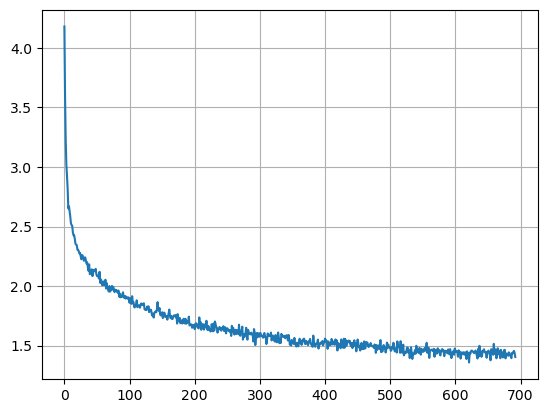

In [61]:
plt.plot([i["step"] for i in record_list], [i["loss"] for i in record_list])
plt.grid()
plt.show()

In [122]:
def inference(model, start_text, max_len=100):
    input = torch.Tensor([char2index[char] for char in start_text]).to(dtype=torch.int64).reshape(1, -1).to(device)
    output = []
    model.eval()
    print(f"Get input : \"{start_text}\"")
    print(">>", end=" ")
    hidden = None
    with torch.no_grad():
        for i in range(max_len):
            logits, hidden = model(input, hidden)
            logits = logits[0, -1, :]

            probs = F.softmax(logits, dim=-1)
            index = torch.multinomial(probs, 1).item()
            input = torch.Tensor([index]).to(dtype=torch.int64, device=device).reshape(1, -1)
            output.append(index)
            
            print(index2char[index], end="", flush=True)

    return "".join([index2char[i] for i in output])

res = inference(model, start_text="hello", max_len=500)

Get input : "hello"
>> w haver day the heaven fellow: house that hath a danchiance to sign this land of conceitied; I shall have doos to palk of sain! O magrieve you,
The vint: she is he must repure their asking,
Take mo never and thing?

CORIOLANUS:
Come, with look, this sasing 'gainst the queen to sprokes of soul.

KING RICHARD III:
Mark your pleasing well, bestre untriud work's high wrath.

BENVOLIO:
Bessenger:
Richard it.

GREET:
If some hore:
In I do lengue, Were I may come and of trem.

KETRRICA:
O have been was